# This notebook simulates satellite coverage across the equator

## Used for experimental purposes

In [1]:
# To use this cell you will need to pip install pyinterval and cartopy. 
# Uncomment below to do so. Note, pip install had issues for cartopy so 
#                we are using the alternative to installing the package

# The additional packages should be included with a basic anaconda install
#                               but they also may be needed for you to run


# pip install pyinterval
# !conda install cartopy

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from interval import interval, inf, imath  

## User inputs for simulation

In [2]:
# number of days we want to simulate
num_days = 1

# number of satellites we wish to simulate -- << 13
satellites = 11

# altitude in meters
h = 400000

# eccentricity
e = .01 

# np.sin takes radians ==> 83° × π/180 = 1.449 rad
inclination = 1.449

# mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
# can be changed to 6378.1343e3 --> This value will convert to exactly
# 40,075 km when evaluating coverage. The mean Earth radius will yield 
# a maximum of 40,035 km
R = 6371.0088e3              

# This chooses which cross on the equator you wish to choose
#   i.e. either the first cross in one period or the second.
#      NOTE: one path we cross is either in daylight or not, 
#                               we are unsure which is which
# 0 --> First Crossing
# 1 --> Second Crossing
equator_choice = 0

# Ω, the longitude of the ascending node will rotate by one degree every day. 
#    This ensures that the orbital plane passes through the same time on each
#                                                       day at each latitude.
Ω = np.pi/4

# Argument of perigee
ω = np.linspace(0,2*np.pi,satellites)

## Defined functions for bulk of work

In [3]:
# FUNCTIONS FOR USE LATER

# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))

# Only used in the 2D plot of Earth reference
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

def xy2q(t, x, y, i, ω, Ω, f=0):                   # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω), np.sin(Ω)]                     # longitude of the ascending node converted to its cosine and sine
    ν = np.sin(i)                                  # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600                      # time (s) converted to orbital plane normal-vector azimuth (radian)
                                                   # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν, np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
                                                   # ν converted to unit normal vector of orbital plane
    λ = np.cross([0, 0, 1], ν)                     # vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,axis=1)**-.5)@λ
                                                   # normalize λ
    μ = np.cross(ν, λ)                             # unit vector orthogonal to λ and to ν
    q = (np.diag(x+f)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                  [W[1],  W[0], 0],
                                                  [   0,     0,  1]])
    return q

def t2q(t, i, ω, Ω,
         a, b, H) :           # create 3D orbit coordinates (q[0],q[1],q[2])
    o = [np.cos(Ω),           # longitude of the ascending node
         np.sin(Ω)]           # ... converted to its cosine and sine
    s = np.sin(i)             # sine of inclination angle, radians
    l = 2*np.pi*t/24/3600     # time (s) converted to orbital plane normal-vector azimuth (radian)
    ν = np.array([np.cos(l)*s,# unit normal vector of orbital plane
                  np.sin(l)*s,
                            np.array([np.cos(i)]*len(l))]).transpose()
    λ = np.cross([0, 0, 1], ν)# vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,   # normalize λ
                       axis=1)**-.5)@λ
    μ = np.cross(ν, λ)        # unit vector orthogonal to λ and to ν
    E = t2E(e, H*t/a/b)       # eq. 25, eccentric anomaly list, radians
    E = E + ω                # eq. 39 implies E ≈ θ when 0 < e << 1
    x = a*np.cos(E)           # eq. 20, x-coordinate list (shifted to ellipse center)
    y = b*np.sin(E)           # eq. 21, y-coordinate list
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[o[0], -o[1], 0],
                                                [o[1],  o[0], 0],
                                                [   0,     0,  1]])
    return q

def coverage_correction_left(interval_correct):
    # Capture what we need
    left_endpoint = interval_correct[0]
    area_covered = interval([0,left_endpoint[1]])
    
    # Remove the negative portion of the crossing
    for i in range(1,np.size(interval_correct,0)):
        area_covered = interval(area_covered) | interval(interval_correct[i])
        
    # Capture the crossing on the other part of the interval
    dist_passed = abs(left_endpoint[0])
    right_int = [2*np.pi - dist_passed, 2*np.pi]
    
    # Insert interval on the end of area_covered
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def coverage_correction_right(interval_correct):
    # Capture what we need
    right_endpoint = interval_correct[-1]
    area_covered = interval([right_endpoint[0],2*np.pi])
    
    # Remove the negative portion of the crossing
    for i in range(0,np.size(interval_correct,0)-1):
        area_covered = interval(area_covered) | interval(interval_correct[i])
        
    # Capture the crossing on the other part of the interval
    dist_passed = abs(right_endpoint[1])
    right_int = [0, dist_passed - 2*np.pi]
    
    # Insert interval on the end of area_covered
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def swath_coverage(theta, h):
    swath = (2 * h * np.tan( ( (np.pi / 180) / 2 ) * theta ))  
    return swath

## The rest of the work

<IPython.core.display.Javascript object>


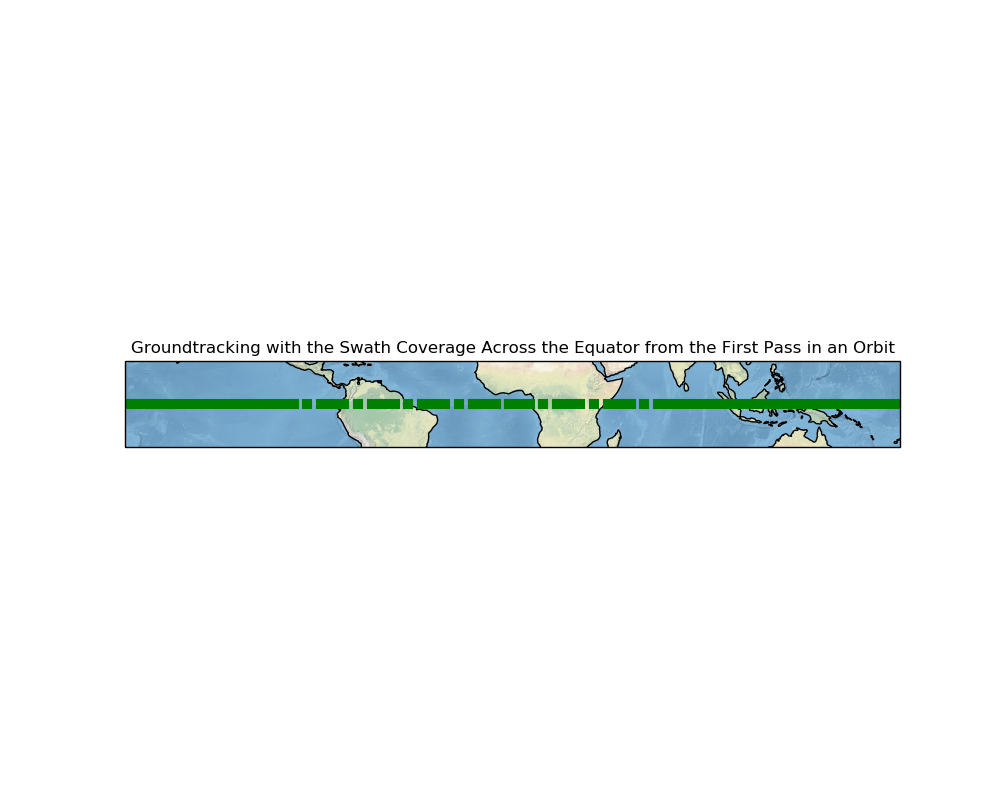

The total coverage at the equator is  33896.578 km for 11 satellites in 1 day(s)
Where the length of the equator is 40030.229 km, based on R defined above.



In [6]:
# HARD SETTING THE PARAMETERS
G = 6.67430e-11                 # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]            # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 350                         # nu. plot points
α = G*sum(m)                    # gravitational parameter, eq. 1, m³/s²
a = (R + h)/(1 - e)             # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)                 # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5             # eq. 15, semi-minor axis
H = (α*p)**.5                   # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5        # eq. 43, orbital period for an elliptic orbit, s

opd = (24*60*60) / P            # roughly 16 orbits in one day -- exactly for a period of 1.5 hours
orbits = (num_days)*opd         # number of orbits we will simulate
swath = swath_coverage(30,h)    # swath based on calculation of altitude 
s = swath/2                     # half the length
eq_length = ((R/1000) * np.pi * 2)

t = np.linspace(0, orbits*P, 4*N)     # time list, s
E = t2E(e, H*t/a/b)                   # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)                 # eq. 20, x-coordinate list
y = b*np.sin(E)                       # eq. 21, y-coordinate list
q = [0]*satellites                    # empty array of size number of satellites

for i in range(0,satellites):         # get x,y,z - coords. for each satellite desired
#    q[i] = xy2q(t, x, y, inclination, ω[i], Ω, 0)
    q[i] = t2q(t, inclination, ω[i], 0, a, b, H)
    
# convert for ground-tracking
psi = [0]*satellites
phi = [0]*satellites

for i in range(0,satellites):
    psi[i] = np.arctan2(q[i][:,0], q[i][:,1])   # x-coordinate for groundtracking
    qq = np.zeros(np.size(q[i][:,2]))
    for j in range(0,np.size(q[i][:,2])):
        qq[j] = q[i][j,2] / np.sqrt( q[i][j,0]**2 + q[i][j,1]**2 + q[i][j,2]**2 )
    phi[i] = np.arcsin( qq )                    # y-coordinate for groundtracking
    
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line

# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []

for i in range(0,satellites):
    for j in range(0,np.size(phi[i])-1):
        if( phi[i][j] > 0 and phi[i][j+1] < 0 ):
            x1.append( psi[i][j] )            # x1
            x2.append( psi[i][j+1] )          # x2
            y1.append( phi[i][j] )            # y1
            y2.append( phi[i][j+1] )          # y2
        else:
            if( phi[i][j] < 0 and phi[i][j+1] > 0 ):
                x1.append( psi[i][j] )            # x1
                x2.append( psi[i][j+1] )          # x2
                y1.append( phi[i][j] )            # y1
                y2.append( phi[i][j+1] )          # y2
                
# Calculating slope of the line crossing the equator.

n = np.size(x1)
slope = []
for i in range(0,n):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  
    
# Centering a point at the equitorial line (a1,b1) each time we cross the equator

# Setting up parameters in order to center a point on an interpolated line at the equator
#       and to calculate the length of the swath crossing the equator, given our angle of  
#                                                                             inclination
u1 = []
v1 = []
a1 = []
b1 = []

for i in range(0,n):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,n):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )  
    
# Calculation of the swath length given our angle

# Converting meters to radians 
m2r = (1/111320) * (1/57.2958)

swath_length = []
for i in range(0,np.size(slope)):
    swath_length.append( s / np.sin( np.arctan( slope[i] ) ) )

for i in range(0,np.size(swath_length)):
    swath_length[i] = swath_length[i] * m2r
    
# Capturing the interval for each pass accross the equator
# Setting up parameters to track the coverage as we pass the equator
equator_catch_plus  = []
equator_catch_minus = []

for i in range(0,n):
    equator_catch_plus.append( a1[i] + swath_length[i] )
    equator_catch_minus.append( a1[i] - swath_length[i] )
       

# ALL CALCULATIONS FOR FIRST PASS ON THE EQUATOR IN ONE PERIOD    
    
if(equator_choice == 0):    

    interval_caught1    = []
    m = np.size(equator_catch_plus)
    for i in range(0,m,2):
        if(equator_catch_plus[i] <= equator_catch_minus[i]):
            interval_caught1.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
        else:
            interval_caught1.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
            
    area_passed_over_eq1 = interval_caught1[0]
    m1 = np.size(interval_caught1,0)

    for i in range(1,m1):
        area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( interval_caught1[i] )
    
    tol = -1e-10
    boo = tol in interval(area_passed_over_eq1[0])
    if( boo == True ):
        area_passed_over_eq1 = coverage_correction_left(area_passed_over_eq1)    
    
    boo = 2*np.pi + tol in interval(area_passed_over_eq1[-1])
    if( boo == True ):
        area_passed_over_eq1 = coverage_correction_right(area_passed_over_eq1)
    
    area_passed_over_eq1_new = area_passed_over_eq1 * (R/1000) # convert to distance traveled in km

    total_coverage1 = 0
    mm1 = ( int(float(np.size(area_passed_over_eq1_new) / 2)) )

    for i in range(0,mm1):
        total_coverage1 = total_coverage1 + ( area_passed_over_eq1_new[i][1] - area_passed_over_eq1_new[i][0])

    equator_inta1 = []
    equator_intb1 = []
    for i in range(0,int(float(np.size(area_passed_over_eq1)/2))):
        equator_inta1.append(area_passed_over_eq1[i][0] - np.pi)
        equator_intb1.append(area_passed_over_eq1[i][1] - np.pi)

    
    # Plotting the groundtracking of the satellite orbits
    %matplotlib notebook

    src_crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=src_crs)
    ax.stock_img()
    ax.coastlines()
    ax.set_extent([-180, 180, -20, 20])
    for i in range(0,np.size(equator_inta1)):
        ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[0,0],'-',c='g')
        ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[1,1],'-',c='g')
        ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[-1,-1],'-',c='g')    
        ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[2,2],'-',c='g')
        ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[-2,-2],'-',c='g') 
    ax.set_title('Groundtracking with the Swath Coverage Across the Equator from the First Pass in an Orbit')
    
    print(f'The total coverage at the equator is {total_coverage1:.3f} km for {satellites} satellites in {num_days} day(s)' )
    print(f'Where the length of the equator is {eq_length:.3f} km, based on R defined above.\n')

# ALL CALCULATIONS FOR SECOND PASS ON THE EQUATOR IN ONE PERIOD        
else:

    interval_caught2    = []
    m = np.size(equator_catch_plus)

    for i in range(1,m,2):
        if(equator_catch_plus[i] <= equator_catch_minus[i]):
            interval_caught2.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
        else:
            interval_caught2.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )

    area_passed_over_eq2 = interval_caught2[0]

    m2 = np.size(interval_caught2,0)

    for i in range(1,m2):
        area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( interval_caught2[i] )

    tol = -1e-10

    boo = tol in interval(area_passed_over_eq2[0])
    if( boo == True ):
        area_passed_over_eq2 = coverage_correction_left(area_passed_over_eq2)    
    
    boo = 2*np.pi + tol in interval(area_passed_over_eq2[-1])
    if( boo == True ):
        area_passed_over_eq2 = coverage_correction_right(area_passed_over_eq2)
    
    area_passed_over_eq2_new = area_passed_over_eq2 * (R/1000) # convert to distance traveled in km

    total_coverage2 = 0
    mm2 = ( int(float(np.size(area_passed_over_eq2_new) / 2)) )

    for i in range(0,mm2):
        total_coverage2 = total_coverage2 + ( area_passed_over_eq2_new[i][1] - area_passed_over_eq2_new[i][0])
    
    equator_inta2 = []
    equator_intb2 = []
    for i in range(0,int(float(np.size(area_passed_over_eq2)/2))):
        equator_inta2.append(area_passed_over_eq2[i][0] - np.pi)
        equator_intb2.append(area_passed_over_eq2[i][1] - np.pi)
    
    %matplotlib notebook

    src_crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=src_crs)
    ax.stock_img()
    ax.coastlines()
    ax.set_extent([-180, 180, -20, 20])
    for i in range(0,np.size(equator_inta2)):
        ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[0,0],'-',c='g')
        ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[1,1],'-',c='g')
        ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[-1,-1],'-',c='g')    
        ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[2,2],'-',c='g')
        ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[-2,-2],'-',c='g') 
    ax.set_title('Groundtracking with the Swath Coverage Across the Equator from the Second Pass in an Orbit')
    
    print(f'The total coverage at the equator is {total_coverage2:.3f} km for {satellites} satellites in {num_days} day(s)' )
    print(f'Where the length of the equator is {eq_length:.3f} km, based on R defined above.\n')